In [25]:
from datetime import datetime
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# List of datasets to compare
# CLOUDS = ["Lille_0", "Lille_11", "Paris_Luxembourg_6", "Speulderbos_2017_TLS"]
# CLOUDS = ["bildstein_station1_xyz_intensity_rgb", "station1_xyz_intensity_rgb", "sg27_station8_intensity_rgb"]
CLOUDS = ["5110_54320", "5135_54435"]
# Input and output folders
PLOT_FOLDER = os.path.join("out", "plots")
os.makedirs(PLOT_FOLDER, exist_ok=True)

# Function to get the file based on the specified timestamp in the filename
def get_file_by_date(folder, date_str):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {folder}")
    
    if date_str == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        latest_file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),  # Join list and then replace
            "%Y-%m-%d-%H:%M:%S"  # Correct datetime format
        ))
        print(f"Loading latest file: {latest_file}")
        return latest_file
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            timestamp_str = filename.split('-')[1:]  # Split to get timestamp part
            timestamp_str = '-'.join(timestamp_str).replace('.csv', '')  # Rebuild timestamp string
            
            if date_str == timestamp_str:
                print(f"Loading file: {file}")
                return file
        raise FileNotFoundError(f"File with date '{date_str}' not found in folder: {folder}")

# Read the latest file for each dataset
dfs = {}
for cloud in CLOUDS:
    folder = os.path.join("out", cloud)
    data = get_file_by_date(folder, 'latest')
    df = pd.read_csv(data)
    # Convert times to milliseconds
    df['mean'] = df['mean'] * 1000
    df['stdev'] = df['stdev'] * 1000
    dfs[cloud] = df

Loading latest file: out/5110_54320/5110_54320-2024-12-04-23:44:48.csv
Loading latest file: out/5135_54435/5135_54435-2024-12-04-23:43:09.csv


In [26]:
# Define a consistent color palette for 'octree' categories
octree_types = set()  # Initialize an empty set
for df in dfs.values():
    octree_types.update(df['octree'].unique())  # Add unique octree values from each dataset

octree_types = sorted(octree_types)  # Sort the octree types
palette = sns.color_palette("Paired", len(octree_types))  # Generate the color palette
color_dict = dict(zip(octree_types, palette))  # Map each octree type to a color

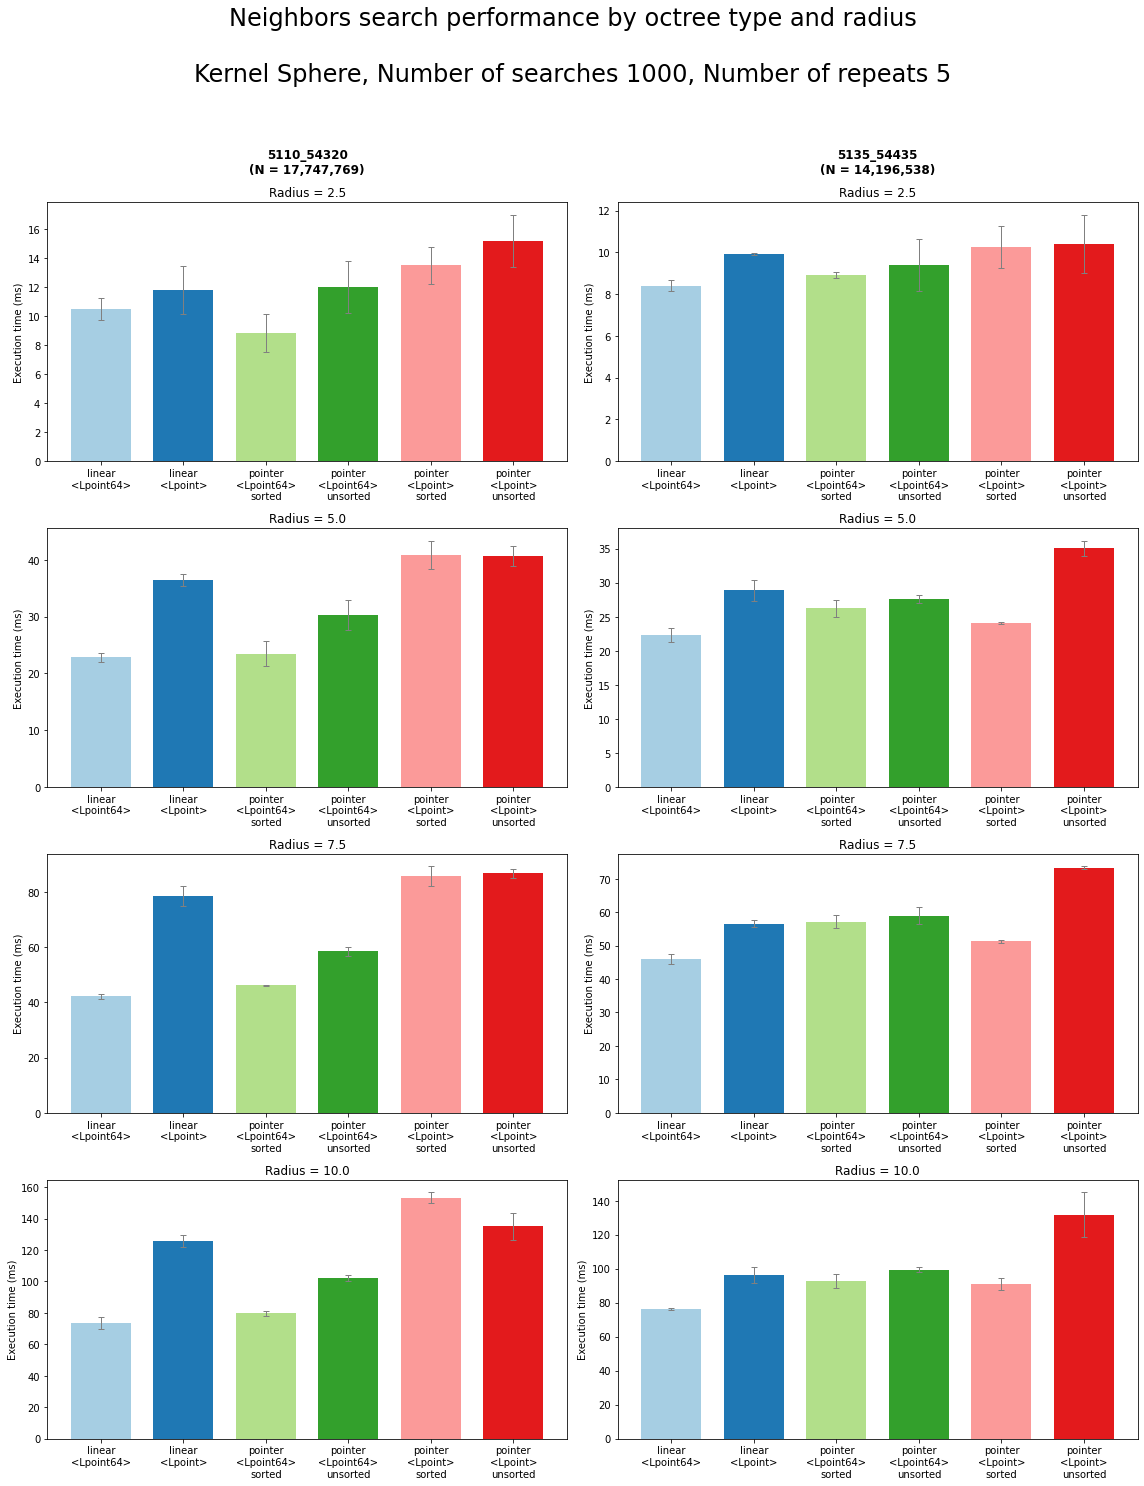

In [27]:
# Function to create a performance plot matrix
def create_comparison_plot_matrix(dfs, kernel, operation, operation_name):
    # Create subplot grid: rows for radius, columns for datasets
    radii = sorted(dfs[next(iter(dfs))]['radius'].unique())  # Assume radius are the same across datasets
    # Define grid size (rows = radius, cols = datasets)
    fig, axes = plt.subplots(len(radii), len(dfs), figsize=(8 * len(dfs), 5 * len(radii)))
   
    bar_width = 0.8  # Adjusted bar width for multiple octree types, reduce if too wide
    bar_gap = 0.1  # Space between bars
    nsearches, nrepeats = 0, 0
    # Iterate over datasets and radius
    for col_idx, (dataset, df) in enumerate(dfs.items()):
        nsearches = df['num_searches'].iloc[0] # The number of searches is in every row of the dataset at column num_searches
        nrepeats = df['repeats'].iloc[0] # The number of repeats is in every row of the dataset at column repeats
        # Filter for the specified operation
        operation_df = df[df['operation'] == operation]
        npoints = df['npoints'].iloc[0] # The number of points is in every row of the dataset at column npoints
        
        # Create plots for each radius
        for row_idx, radius in enumerate(radii):
            ax = axes[row_idx][col_idx]
            radius_data = operation_df[operation_df['radius'] == radius]
           
            # Only include 'sphere' kernel
            sphere_data = radius_data[radius_data['kernel'] == kernel]
           
            # Sort octree types to ensure consistent order
            octree_types_sorted = sorted(sphere_data['octree'].unique())
            
            # Adjust spacing between bars based on sorted octree types
            for i, octree in enumerate(octree_types_sorted):
                octree_data = sphere_data[sphere_data['octree'] == octree]
               
                # Extract means and standard deviations
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
               
                # Position bars with adjusted spacing
                x_pos = i * (1 + bar_gap)
               
                # Plot bars and error bars for each octree
                ax.bar(x_pos, means[0], bar_width, color=color_dict[octree], label=octree)
                ax.errorbar(x_pos, means[0], stdevs[0], color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
           
            # Ticks with the different octree names
            ax.set_xticks([i * (1 + bar_gap) for i in range(len(octree_types_sorted))])
            ax.set_xticklabels([label.replace(' ', '\n') for label in octree_types_sorted])
            ax.set_ylabel('Execution time (ms)')
           
            # Radius subtitle
            ax.set_title(f'Radius = {radius}')
            
            # Dataset title
            if row_idx == 0:
                ax.text(0.5, 1.1, f"{dataset}\n(N = {npoints:,})", transform=ax.transAxes, 
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Overall title
    fig.suptitle(operation_name + f' performance by octree type and radius\n\nKernel {kernel}, Number of searches {nsearches}, Number of repeats {nrepeats}', 
                 y=1.03, fontsize=24)
   
    plt.tight_layout()
    return fig

# Create the comparison plot for 'neighSearch'
fig = create_comparison_plot_matrix(dfs, "Sphere", 'neighSearch', 'Neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'neighbor_search_comparison.png'), dpi=300, bbox_inches='tight', facecolor='white')

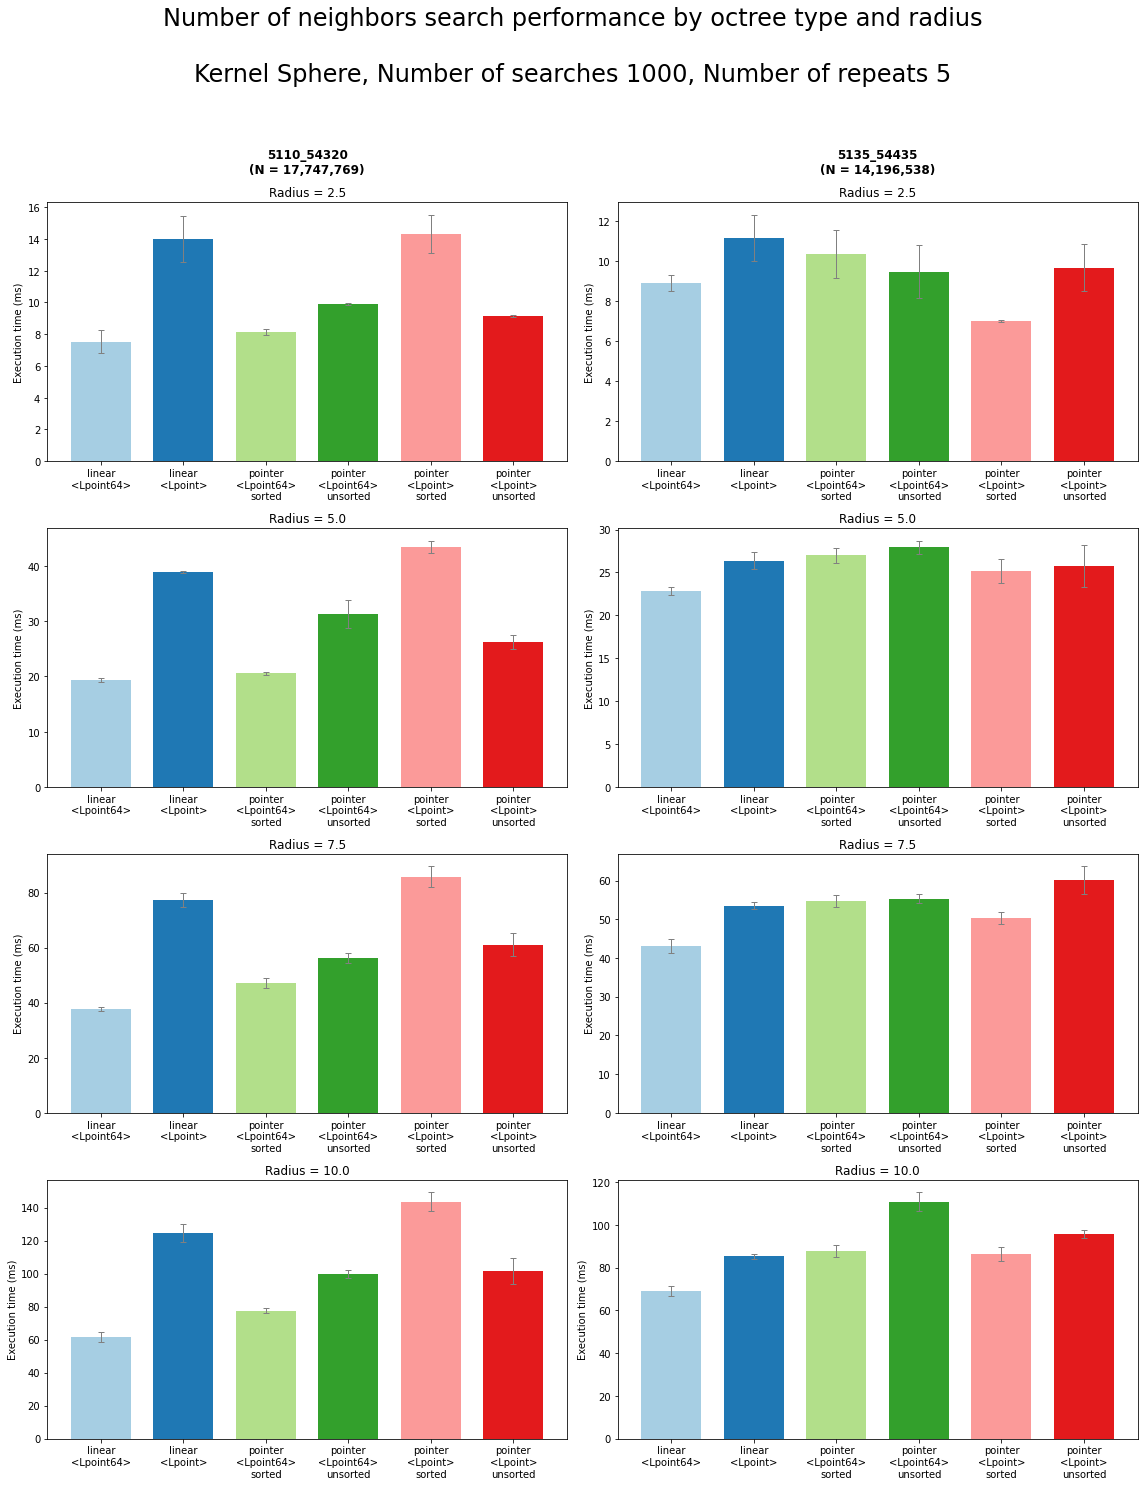

In [28]:
# Create the comparison plot for 'neighSearch'
fig = create_comparison_plot_matrix(dfs, "Sphere", 'numNeighSearch', 'Number of neighbors search')
plt.savefig(os.path.join(PLOT_FOLDER, 'num_neighbor_search_comparison.png'), dpi=300, bbox_inches='tight', facecolor='white')